### Importing necessary libraries

In [205]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

### Opening the file and reading the data from it

In [206]:
file = "../data/cleaned/Cleaned_2.csv"
df = pd.read_csv(file)

### Updating 'state_construction' values for better readability and clarity:

The code snippet modifies the 'state_construction' column in the DataFrame by replacing certain values with more descriptive ones. The replacements are as follows:

- 'TO_RESTORE', 'TO_RENOVATE', and 'TO_BE_DONE_UP' are replaced with "To Restore", indicating properties that require renovation.
- 'JUST_RENOVATED' is replaced with "Good", indicating recently renovated properties.
- 'GOOD' is retained as "Good", indicating properties in good condition.
- 'AS_NEW' is replaced with "Excellent", indicating properties in excellent condition.

This update aims to enhance the readability and clarity of the 'state_construction' values for better interpretation and analysis.

In [207]:
# Updating 'state_construction' values for better readability and clarity.
df['state_construction'] = df.state_construction.replace({
    'TO_RESTORE': "To Restore",
    "TO_RENOVATE": "To Restore",
    "TO_BE_DONE_UP": "To Restore",
    "JUST_RENOVATED":"Good",
    "GOOD":"Good",
    "AS_NEW":"Excellent"
    })

### Creating a DataFrame of population data by province in Belgium:

The provided code initializes lists containing province names and their corresponding populations. Subsequently, a dictionary is created to associate each province name with its population. This dictionary is then used to construct a DataFrame named 'df_population_by_province', where each row represents a province with its respective population.

- `provinces_names`: A list containing the names of provinces in Belgium.
- `population_per_province`: A list containing the populations corresponding to each province.
- `population_per_province`: A dictionary created by pairing province names with their respective populations.
- `df_population_by_province`: A DataFrame constructed from the population data, where each row represents a province along with its population.

This process facilitates the organization and analysis of population data by province for further insights and visualization.


In [208]:
# List of province names in Belgium.
provinces_names = [
    'brussels', 'antwerp', 'limburg','east flanders', 'flemish brabant',
    'west flanders', 'walloon brabant', 'hainaut', 'liège', 'luxembourg',
    'namur'
    ]

# List of province names in Belgium.
population_per_province = [
    1222637, 1886609, 885951, 1543865, 1173440,
    1209011, 409782, 1351127, 1110989, 291143,
    499454
    ]

# Creating a dictionary to associate province names with their respective populations.
population_per_province = {
    'province': provinces_names,
    'population': population_per_province}

# Creating a DataFrame from the population data by province.
df_population_by_province = pd.DataFrame(population_per_province)

### Calculating median price and number of properties per province:

The provided code calculates the median price and number of properties per province from a DataFrame named 'df' (our main DataFrame). Two separate operations are performed:

1. Median Price Calculation:
    - The median price per province is computed by grouping the DataFrame 'df' by the 'province' column and calculating the median of the 'price' column for each group.
    - The resulting series is sorted in descending order based on median price.
    - The output is stored in a variable named 'median_price_per_province'.

2. Number of Properties Calculation:
    - The number of properties per province is determined by counting the occurrences of each province in the 'province' column of the DataFrame 'df'.
    - The counts are sorted by province name.
    - The output is stored in a variable named 'number_of_properties_per_province'.

These calculations provide insights into the distribution of property prices and availability across different provinces, aiding in further analysis and decision-making processes.


In [209]:
# Calculating median price per province, sorted in descending order.
median_price_per_province = df.groupby('province')['price'].median().sort_values(ascending=False)

# Counting the number of properties per province, sorted by province name.
number_of_properties_per_province = df['province'].value_counts().sort_index()

### Merging and Visualizing Provincial Property Data:

The provided code snippet performs the following tasks:

1. Merging Dataframes:
    - The median price per province and the number of properties per province dataframes are merged based on the 'province' column.
    - The resulting merged dataframe is then merged with the population data by province.

2. Formatting Province Names:
    - Each word in the 'province' column of the merged dataframe is converted to uppercase for better readability.

3. Visualization:
    - A scatter plot is created using Plotly Express to visualize the relationship between the number of properties listed for sale ('count'), the median price of properties ('price'), and the population per province.
    - The size of the markers in the scatter plot represents the population of each province, and the color represents the province.
    - The plot is displayed with a logarithmic scale for the x-axis (number of properties) for better visualization.
    - The plot includes tooltips displaying the province names when hovering over the data points.

4. Plot Layout:
    - The title of the plot is set to 'Provincial Property Markets: Number of Listings vs. Average Price and Population'.
    - The x-axis title is set to 'Number of Properties Listed for Sale', and the y-axis title is set to 'Median Price of Properties (€)'.

This visualization provides insights into the provincial property markets, illustrating the distribution of properties, median prices, and population across different provinces in Belgium.


In [229]:
# Merging median price and number of properties dataframes based on province.
merged_df = pd.merge(median_price_per_province, number_of_properties_per_province, on='province')

# Merging the merged_df with the population data by province.
merged_df = pd.merge(merged_df, df_population_by_province, on='province')

# Make each word in the province names appear with big letters to better readability
merged_df['province'] = merged_df['province'].apply(lambda x: ' '.join(word.upper() for word in x.split()))

# Creating a scatter plot to visualize the relationship between
# number of properties, median price, and population per province.
fig = px.scatter(merged_df, x="count", y="price",
	            size="population", size_max=60,
                color="province", hover_name="province",
                text="province", #log_x=True,
                labels={'province': 'Province'})

# Updating layout of the plot.
fig.update_layout(
    title='Provincial Property Markets: Number of Listings vs. Average Price and Population',
    xaxis_title='Number of Properties Listed for Sale',
    yaxis_title='Median Price of Properties (€)',
)

fig.show()

In [211]:
# Grouping data by province and state_construction, calculating counts.
df_province_by_state_construction = df.groupby('province')['state_construction'].value_counts()

# Grouping total counts by province.
total_counts = df_province_by_state_construction.groupby(level=0).sum()

# Calculating percentage of each state_construction per province.
df_province_by_state_construction_percentage = df_province_by_state_construction / total_counts

# Resetting index and renaming column.
df_percentage_reset = df_province_by_state_construction_percentage.reset_index(name='percentage')

# Pivoting data for visualization.
df_pivoted = df_percentage_reset.pivot(index='province', columns='state_construction', values='percentage')

# Creating a figure for visualization.
fig = go.Figure()

# Adding traces for each state_construction category.
for column in df_pivoted.columns:
    fig.add_trace(go.Bar(x=df_pivoted.index, y=df_pivoted[column], name=column))

# Updating layout of the plot.
fig.update_layout(
    barmode='stack',
    title='Percentage of House Conditions by Province',
    xaxis_title='Province',
    yaxis_title='Percentage',
    yaxis_tickformat='.1%'
    )

fig.show()

---

# Not needed for the presentation.

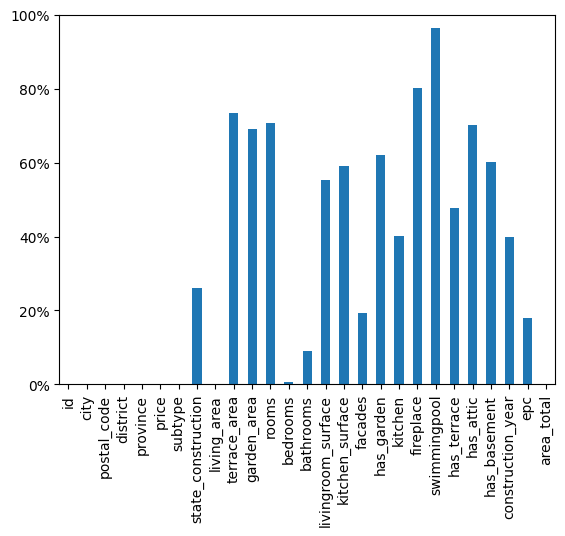

In [212]:
import matplotlib.pyplot as plt

number_of_rows = df.shape[0]
number_of_nan_rows = df.isna().sum()
percentage_of_nan = (number_of_nan_rows / number_of_rows) * 100

percentage_of_nan.plot(kind='bar')
plt.ylim(0, 100)
ticks = np.arange(0, 101, step=20)

plt.yticks(ticks, [f"{tick}%" for tick in ticks])

plt.show()

In [213]:
print('Number of properties left after cleaning:', df.shape[0])

Number of properties left after cleaning: 30554


In [214]:
df.columns

Index(['id', 'city', 'postal_code', 'district', 'province', 'price', 'subtype',
       'state_construction', 'living_area', 'terrace_area', 'garden_area',
       'rooms', 'bedrooms', 'bathrooms', 'livingroom_surface',
       'kitchen_surface', 'facades', 'has_garden', 'kitchen', 'fireplace',
       'swimmingpool', 'has_terrace', 'has_attic', 'has_basement',
       'construction_year', 'epc', 'area_total'],
      dtype='object')

In [215]:
fig = px.pie(df, names='subtype', title='Type of Real Estate in Belgium')
fig.show()

In [216]:
# FIX IT! BECAUSE IT'S WRONG :(

median_price_per_province = df.groupby('province')['price'].median().sort_values(ascending=False)
number_of_properties_per_province = df['province'].value_counts().sort_index()

px.bar(df, x=median_price_per_province.index, y=median_price_per_province.values, color=number_of_properties_per_province.values, labels ={
    'x':'Province',
    'y':'Median Price of Properties (€)',
    'color':'Number of Properties Listed for Sale'
    })


Brussels significantly more expansive and have more properties for sale

Waloon Brabant: expensive, few properties.
Hainaut: cheap, many properties.
 
Outliers:
1) Luxembourg, Namur, Liege: cheap, few properties.
2) West Flanders: expensive, many properties.

In [217]:
df['state_construction'] = df.state_construction.replace({
    'TO_RESTORE': "To Restore",
    "TO_RENOVATE": "To Restore",
    "TO_BE_DONE_UP": "To Restore",
    "JUST_RENOVATED":"Good",
    "GOOD":"Good",
    "AS_NEW":"Excellent"
    })

df_province_by_state_construction = df.groupby('province')['state_construction'].value_counts()
total_counts = df_province_by_state_construction.groupby(level=0).sum()
df_province_by_state_construction_percentage = df_province_by_state_construction / total_counts
df_percentage_reset = df_province_by_state_construction_percentage.reset_index(name='percentage')
df_pivoted = df_percentage_reset.pivot(index='province', columns='state_construction', values='percentage')

fig = go.Figure()

for column in df_pivoted.columns:
    fig.add_trace(go.Bar(x=df_pivoted.index, y=df_pivoted[column], name=column))

fig.update_layout(
    barmode='stack',
    title='Percentage of House Conditions by Province',
    xaxis_title='Province',
    yaxis_title='Percentage',
    yaxis_tickformat='.1%'
    )

fig.show()

In [218]:
# Create the histogram
fig1 = px.histogram(df, x="state_construction", histnorm='percent')
fig1.update_yaxes(range=[0, 100])

# Create the bar chart
mean_price_per_state_construction = df.groupby('state_construction')['price'].median()
fig2 = px.bar(x=mean_price_per_state_construction.index, y=mean_price_per_state_construction.values, labels={'x':'State of the construction', 'y':'mean price'})

# Create a figure with subplots
fig = go.Figure()

# Add the histogram to the figure
fig.add_trace(fig1.data[0])

# Add the bar chart to the figure
fig.add_trace(fig2.data[0])

# Hide the second trace (the bar chart) by default
fig.data[1].visible = False

# Create a dropdown menu
buttons = [
    dict(label="State of construction in %", method="update", args=[{"visible": [True, False]}]),
    dict(label="Mean Price of each state", method="update", args=[{"visible": [False, True]}])
]

# Add the dropdown menu to the figure
fig.update_layout(updatemenus=[dict(buttons=buttons)])

# Show the figure
fig.show()

In [219]:
df.head()

,id,city,postal_code,district,province,price,subtype,state_construction,living_area,terrace_area,...,has_garden,kitchen,fireplace,swimmingpool,has_terrace,has_attic,has_basement,construction_year,epc,area_total
0,1882546,wenduine,8420,oostend,west flanders,163000.0,CHALET,Excellent,62.0,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2023.0,NaN,155.0
1,2784938,heist-aan-zee,8301,brugge,west flanders,108000.0,BUNGALOW,Excellent,51.0,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2023.0,NaN,170.0
2,6675519,zonhoven,3520,hasselt,limburg,392422.0,HOUSE,NaN,206.0,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2023.0,NaN,370.0
3,7066131,bredene,8450,oostend,west flanders,245000.0,HOUSE,Excellent,76.0,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2023.0,B,150.0
4,7222190,geel,2440,turnhout,antwerp,335527.0,HOUSE,NaN,160.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,431.0


In [220]:
# KEEP IT AND WORK ON IT

provinces_names = [
    'brussels', 'antwerp', 'limburg','east flanders', 'flemish brabant',
    'west flanders', 'walloon brabant', 'hainaut', 'liège', 'luxembourg',
    'namur'
    ]

population_per_province = [
    1222637, 1886609, 885951, 1543865, 1173440,
    1209011, 409782, 1351127, 1110989, 291143,
    499454
    ]

population_per_province = {
    'province': provinces_names,
    'population': population_per_province}

df_population_by_province = pd.DataFrame(population_per_province)

df_population_by_province

merged_df = pd.merge(median_price_per_province, number_of_properties_per_province, on='province')
merged_df = pd.merge(merged_df, df_population_by_province, on='province')

fig = px.scatter(merged_df, x="count", y="price",
	         size="population", color="province",
                 hover_name="province", log_x=True, size_max=60, text="province")

fig.update_layout(
    title='Provincial Property Markets: Number of Listings vs. Average Price and Population',
    xaxis_title='Number of Properties Listed for Sale',
    yaxis_title='Median Price of Properties (€)',
)

fig.show()

In [221]:
merged_df

,province,price,count,population
0,brussels,675000.0,910,1222637
1,flemish brabant,459637.0,3372,1173440
2,walloon brabant,450000.0,1451,409782
3,antwerp,415000.0,4715,1886609
4,east flanders,392215.0,5087,1543865
5,west flanders,373947.5,4316,1209011
6,limburg,356133.0,1475,885951
7,luxembourg,309750.0,1036,291143
8,namur,285000.0,1344,499454
9,liège,265000.0,2873,1110989


In [222]:
merged_df['properties_per_100,000'] = (merged_df['count'] / merged_df['population']) * 100000

In [223]:
merged_df

,province,price,count,population,"properties_per_100,000"
0,brussels,675000.0,910,1222637,74.429287
1,flemish brabant,459637.0,3372,1173440,287.360240
2,walloon brabant,450000.0,1451,409782,354.090712
3,antwerp,415000.0,4715,1886609,249.919300
4,east flanders,392215.0,5087,1543865,329.497722
5,west flanders,373947.5,4316,1209011,356.985999
6,limburg,356133.0,1475,885951,166.487763
7,luxembourg,309750.0,1036,291143,355.838883
8,namur,285000.0,1344,499454,269.093850
9,liège,265000.0,2873,1110989,258.598420


In [224]:
# Change provinces to Title

fig = px.scatter(
    merged_df, x="properties_per_100,000", y="price",
	color="province", hover_name="province", size="properties_per_100,000",
    text="province", size_max=50)

fig.update_layout(
    title='Average House Prices and Property Listings by Province',
    xaxis_title='Number of Properties Listed per 100,000 People',
    yaxis_title='Average Property Price (€)',
)

In [225]:
colors = px.colors.qualitative.Dark24


In [226]:
fig = px.scatter(
    merged_df, x="properties_per_100,000", y="price", hover_name="province",
    text="province"
)

fig.update_layout(
    title='Average House Prices and Property Listings by Province',
    xaxis_title='Number of Properties Listed per 100,000 People',
    yaxis_title='Average Property Price (€)'
)

fig.show()
